# Load Dataset and Library

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [26]:
df = pd.read_csv('mergedata2.csv')

In [27]:
df.head()

,date_submitted,score,code_module,gender,region,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date,sum_click
0,19.0,70.0,BBB,F,East Anglian Region,Lower Than A Level,35-55,0,60,N,Pass,-5.0,1.0
1,19.0,70.0,BBB,F,East Anglian Region,Lower Than A Level,35-55,0,60,N,Pass,-5.0,1.0
2,19.0,70.0,BBB,F,East Anglian Region,Lower Than A Level,35-55,0,60,N,Pass,-5.0,7.0
3,19.0,70.0,BBB,F,East Anglian Region,Lower Than A Level,35-55,0,60,N,Pass,-5.0,3.0
4,19.0,70.0,BBB,F,East Anglian Region,Lower Than A Level,35-55,0,60,N,Pass,-5.0,1.0


# EDA

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14176608 entries, 0 to 14176607
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_submitted        float64
 1   score                 float64
 2   code_module           object 
 3   gender                object 
 4   region                object 
 5   highest_education     object 
 6   age_band              object 
 7   num_of_prev_attempts  int64  
 8   studied_credits       int64  
 9   disability            object 
 10  final_result          object 
 11  date                  float64
 12  sum_click             float64
dtypes: float64(4), int64(2), object(7)
memory usage: 1.4+ GB


Kategorikal

Uji chi-square akan memberi kita p-value yang menunjukkan apakah distribusi dari fitur kategorikal berbeda antar kelas dalam final_result. Jika p-value rendah (misalnya di bawah 0,05), maka kita dapat menyimpulkan bahwa fitur kategorikal tersebut memiliki hubungan yang signifikan dengan final_result

In [29]:
from scipy.stats import chi2_contingency

categorical_features = ['code_module', 'gender', 'region', 'highest_education', 'age_band', 'disability']
p_values = {}

for feature in categorical_features:
    contingency = pd.crosstab(df[feature], df['final_result'])
    _, p, _, _ = chi2_contingency(contingency)
    p_values[feature] = p

p_values_df = pd.Series(p_values).sort_values()

p_values_df

gender               0.0
region               0.0
highest_education    0.0
age_band             0.0
disability           0.0
code_module          1.0
dtype: float64

In [30]:
ordinal_mapping = {
    'Fail': 0,
    'Withdrawn': 1,
    'Pass': 2,
    'Distinction': 3
}

df['final_result_ordinal'] = df['final_result'].map(ordinal_mapping)

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
ordinal_correlations = df[numeric_cols].corr()['final_result_ordinal'].drop('final_result_ordinal').sort_values(ascending=False)

ordinal_correlations

score                   0.221204
date                    0.113819
date_submitted          0.106181
sum_click               0.023246
studied_credits        -0.047566
num_of_prev_attempts   -0.144470
Name: final_result_ordinal, dtype: float64

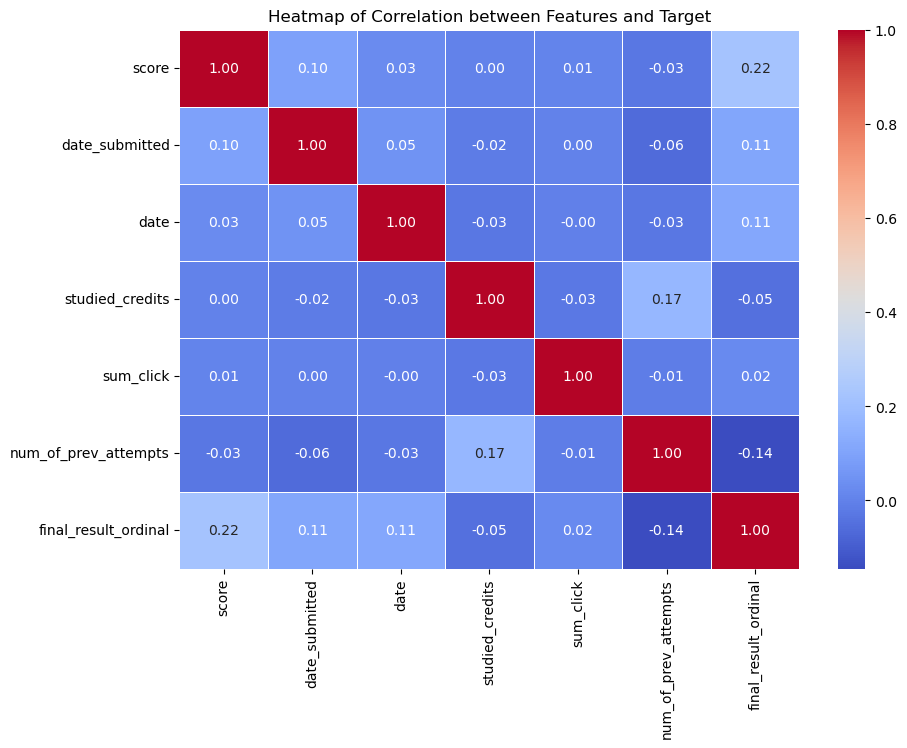

In [31]:
selected_features = ['score', 'date_submitted', 'date', 'studied_credits', 'sum_click', 'num_of_prev_attempts', 'final_result_ordinal']
correlation_matrix = df[selected_features].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Heatmap of Correlation between Features and Target")
plt.show()

Dari heatmap di atas, kita dapat melihat korelasi antara fitur numerik dengan final_result dalam format ordinal (dilambangkan sebagai final_result_ordinal):
- Fitur score memiliki korelasi positif tertinggi dengan target
- Fitur num_of_prev_attempts memiliki korelasi negatif tertinggi dengan target.
- Fitur lainnya juga menunjukkan korelasi dengan target, meskipun beberapa korelasinya tidak sekuat yang lain.

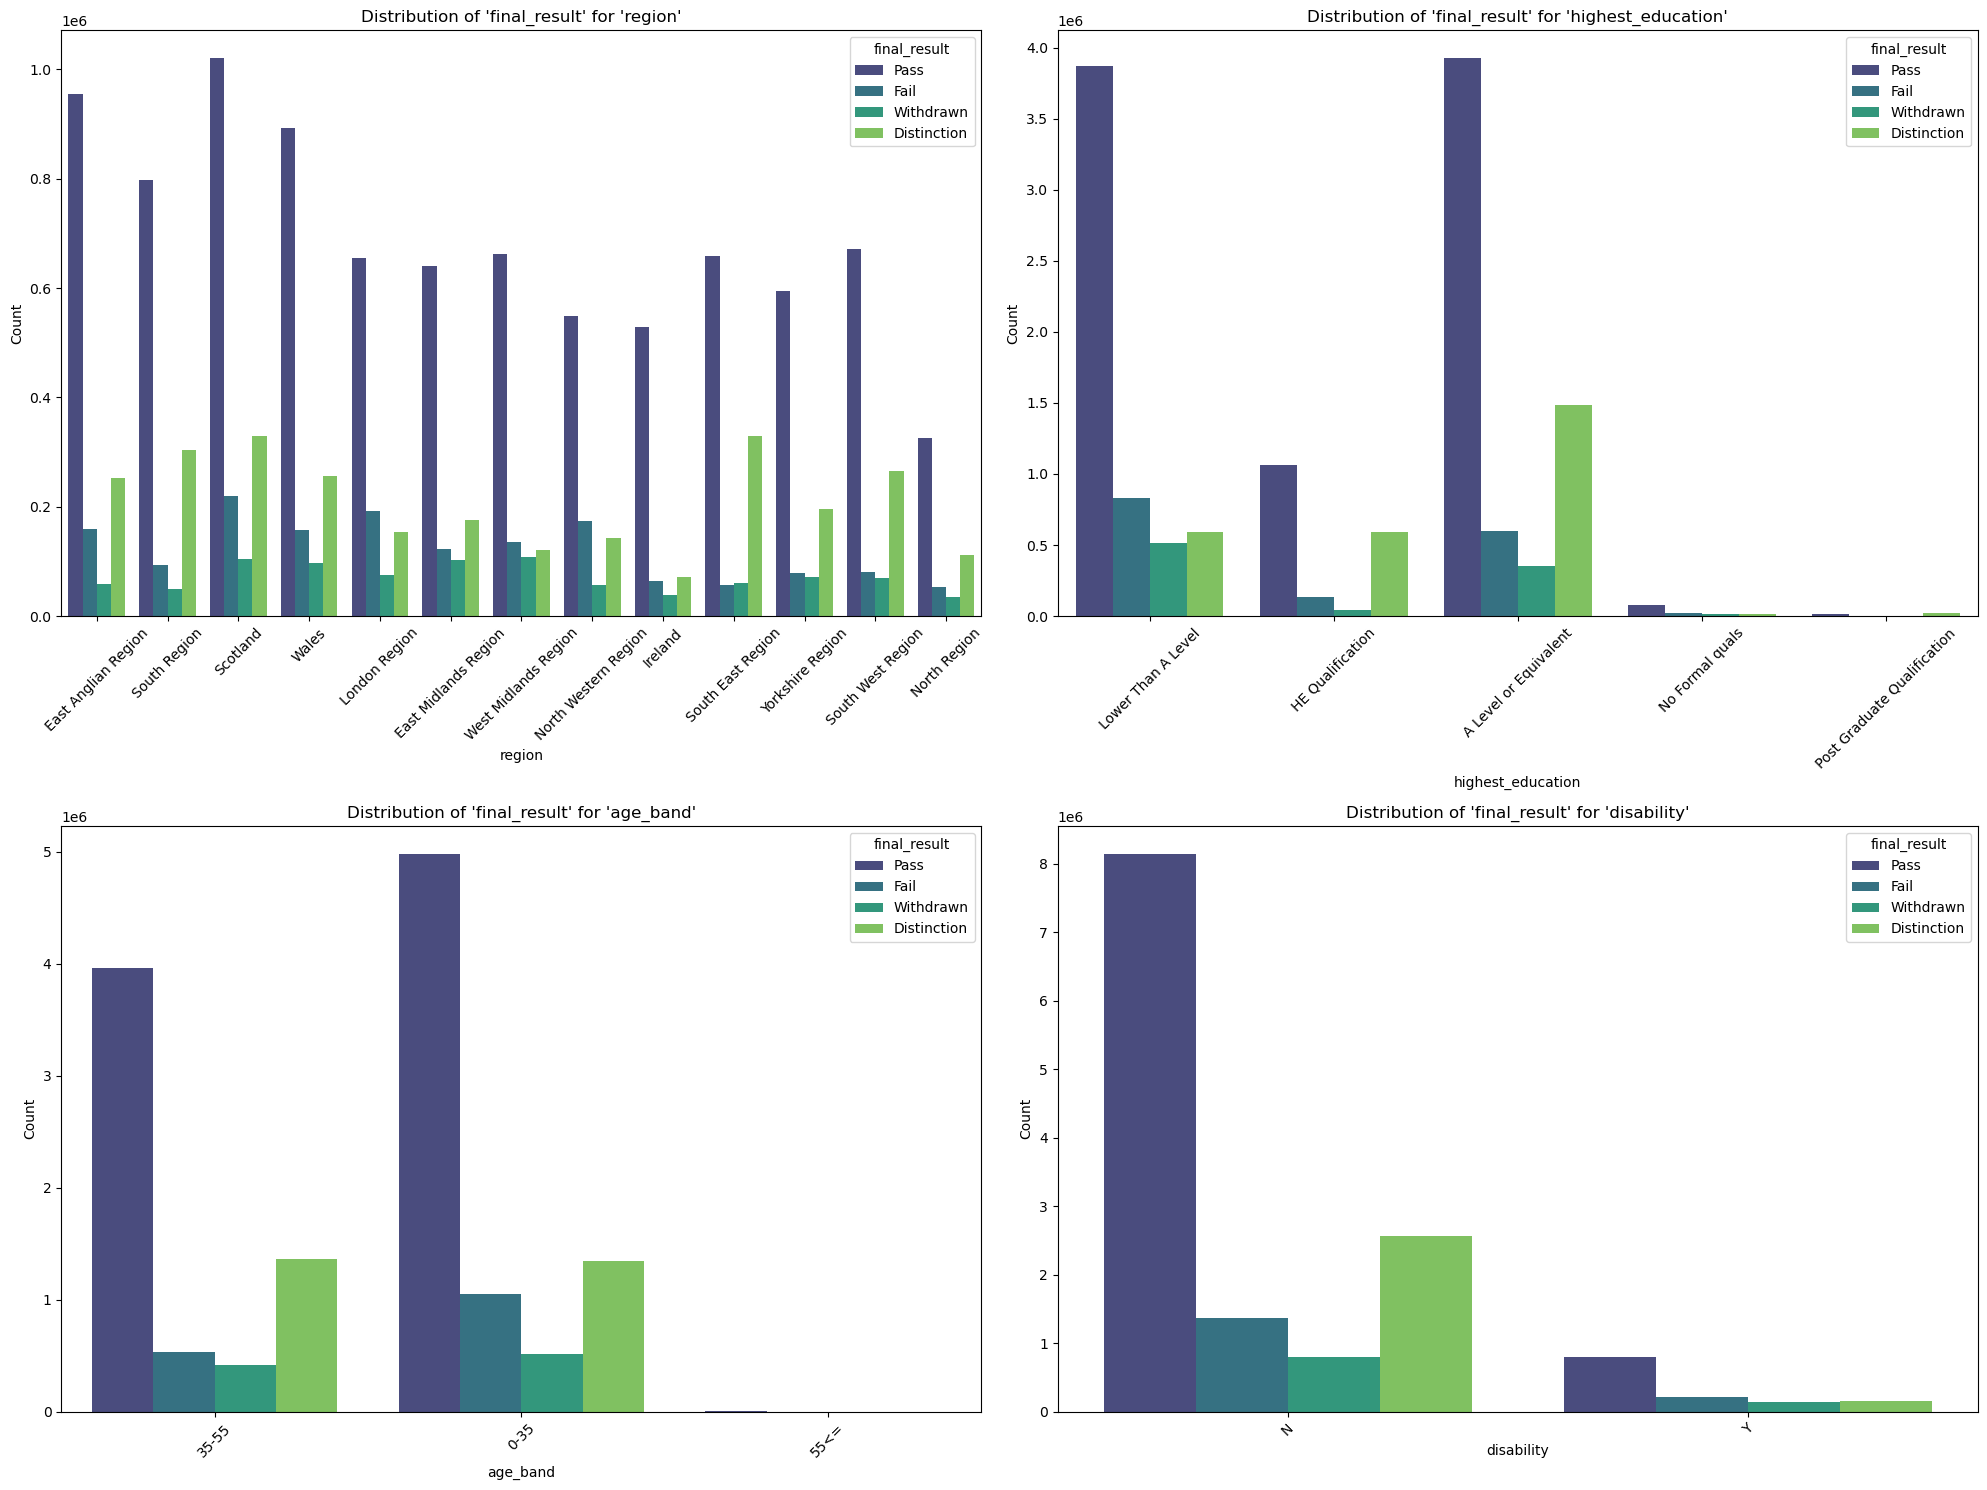

In [32]:
categorical_features_to_visualize = ['region', 'highest_education', 'age_band', 'disability']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features_to_visualize, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=feature, hue='final_result', palette='viridis')
    plt.title(f"Distribution of 'final_result' for '{feature}'")
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Dari visualisasi di atas, berikut adalah beberapa observasi:
- Region: Beberapa wilayah menunjukkan distribusi final_result yang berbeda. Sebagai contoh, Scotland memiliki proporsi "Distinction" yang lebih tinggi dibandingkan dengan "Pass", sedangkan untuk sebagian besar wilayah lain, "Pass" mendominasi.
- Highest Education: Siswa dengan pendidikan tertinggi "Post Graduate Qualification" cenderung memiliki proporsi "Distinction" yang lebih tinggi dibandingkan dengan kelompok lain.
- Age Band: Siswa dalam kelompok usia "0-35" memiliki proporsi "Distinction" yang lebih tinggi dibandingkan dengan "Pass", sedangkan untuk kelompok usia lain, "Pass" mendominasi.
- Disability: Distribusi antara siswa yang memiliki disabilitas ('Y') dan yang tidak ('N') tampaknya serupa, meskipun ada beberapa perbedaan relatif.

# Pre Processing Data

In [33]:
# Features and target
X = df[['gender', 'region', 'highest_education', 'age_band', 'disability', 'date_submitted', 
          'date', 'studied_credits', 'sum_click', 'num_of_prev_attempts', 'score']]
y = df['final_result_ordinal']

In [34]:
# One-hot encoding for categorical features and scaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['date_submitted', 'date', 'studied_credits', 'sum_click', 'num_of_prev_attempts', 'score']),
        ('cat', OneHotEncoder(drop='first'), ['gender', 'region', 'highest_education', 'age_band', 'disability'])
    ])


In [35]:

X_processed = preprocessor.fit_transform(X)

# Spliting Data

In [36]:
# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape


((11341286, 26), (2835322, 26))

# Membangun Model

In [37]:
# Define the model architecture
model = Sequential()

# Input layer
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer (4 classes: Fail, Withdrawn, Pass, Distinction)
model.add(Dense(4, activation='softmax'))

In [38]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3456      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 13924 (54.39 KB)
Trainable params: 13924 (54.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train Model

In [40]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
177208/177208 [==============================] - 289s 2ms/step - loss: 0.5831 - accuracy: 0.7631 - val_loss: 0.5352 - val_accuracy: 0.7806
Epoch 2/10
177208/177208 [==============================] - 309s 2ms/step - loss: 0.5222 - accuracy: 0.7850 - val_loss: 0.5084 - val_accuracy: 0.7901
Epoch 3/10
177208/177208 [==============================] - 314s 2ms/step - loss: 0.5004 - accuracy: 0.7938 - val_loss: 0.5039 - val_accuracy: 0.7936
Epoch 4/10
177208/177208 [==============================] - 315s 2ms/step - loss: 0.4866 - accuracy: 0.8000 - val_loss: 0.4846 - val_accuracy: 0.7997
Epoch 5/10
177208/177208 [==============================] - 315s 2ms/step - loss: 0.4773 - accuracy: 0.8043 - val_loss: 0.4760 - val_accuracy: 0.8051
Epoch 6/10
177208/177208 [==============================] - 315s 2ms/step - loss: 0.4702 - accuracy: 0.8074 - val_loss: 0.4633 - val_accuracy: 0.8105
Epoch 7/10
177208/177208 [==============================] - 318s 2ms/step - loss: 0.4646 - accuracy:

# Evaluasi

In [41]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


88604/88604 [==============================] - 102s 1ms/step - loss: 0.4514 - accuracy: 0.8169
Test Loss: 0.4514
Test Accuracy: 0.8169


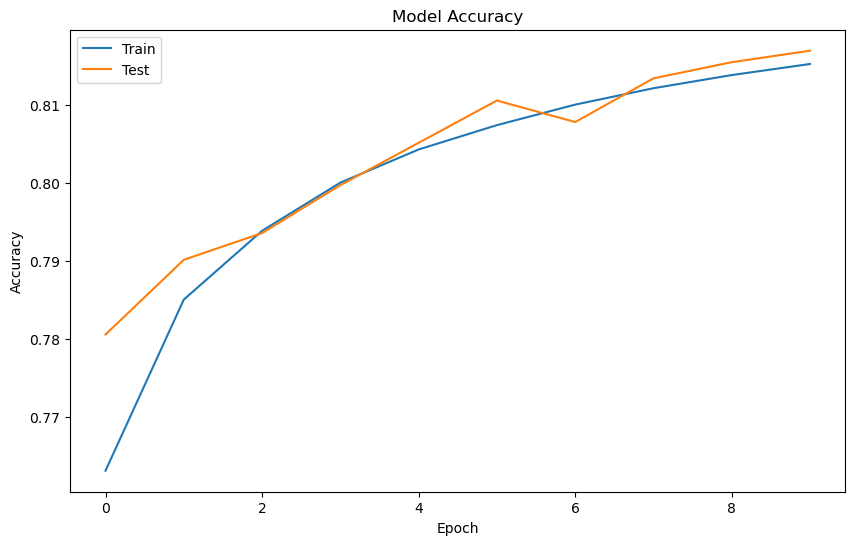

In [42]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [43]:
# Predict probabilities
predictions = model.predict(X_test)

# Convert probabilities to class labels
predicted_labels = predictions.argmax(axis=1)


88604/88604 [==============================] - 90s 1ms/step


Confusion Matriks

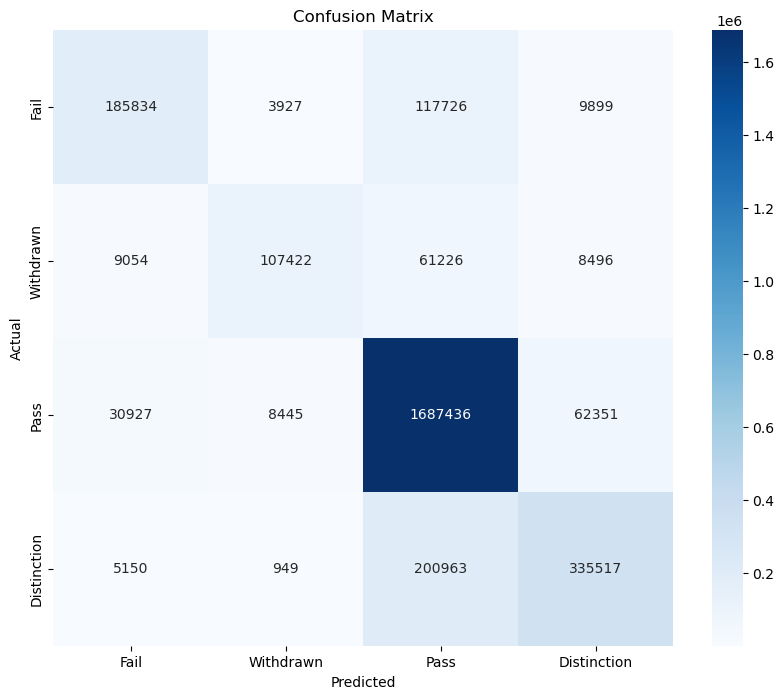

              precision    recall  f1-score   support

        Fail       0.80      0.59      0.68    317386
   Withdrawn       0.89      0.58      0.70    186198
        Pass       0.82      0.94      0.88   1789159
 Distinction       0.81      0.62      0.70    542579

    accuracy                           0.82   2835322
   macro avg       0.83      0.68      0.74   2835322
weighted avg       0.82      0.82      0.81   2835322



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fail', 'Withdrawn', 'Pass', 'Distinction'], yticklabels=['Fail', 'Withdrawn', 'Pass', 'Distinction'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, predicted_labels, target_names=['Fail', 'Withdrawn', 'Pass', 'Distinction']))


Kurva ROC

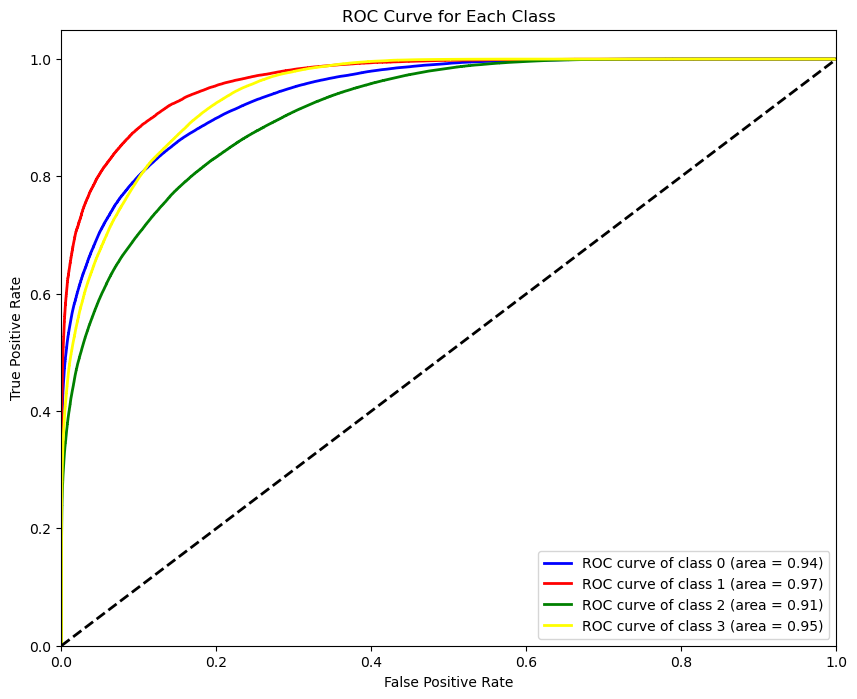

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'yellow']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()
